# Variational Quantum Eigensolver

A variational quantum eigensolver is a variational quantum algorithm where a parametrized quantum circuit is trained to prepare the ground state of a target Hamiltonian [See A. Peruzzo et al. - 2013](https://arxiv.org/abs/1304.3061).

<img src="./figures/vqe.png" width="800" height="500" alt="My Image">

As sketched above, the idea is that we get a state from a quantum circuit, and this state depends on the parameters of the circuit. Then we implement a machine learning routine to update the parameters of the circuit such that the expectation value of our target Hamiltonian on this state is minimized.

### Some imports

In [ ]:
import numpy as np

import torch.optim as optim

from qibo import (
    Circuit, 
    gates, 
    hamiltonians, 
    set_backend, 
    construct_backend,
)

from qiboml.models.decoding import Expectation
from qiboml.interfaces.pytorch import QuantumModel

### The chosen model

We choose a layered model, where a parametric structure composed of rotations and controlled rotations is repeated `nlayers` times.

In [3]:
# Setting number of qubits of the problem and number of layers.
nqubits = 4
nlayers = 3

In [4]:
# Structure of the VQE ansatz
def build_vqe_circuit(nqubits, nlayers):
    """Construct a layered, trainable ansatz."""
    c = Circuit(nqubits)
    for _ in range(nlayers):
        for q in range(nqubits):
            c.add(gates.RY(q=q, theta=np.random.randn()))
            c.add(gates.RZ(q=q, theta=np.random.randn()))
        [c.add(gates.CRX(q0=q%nqubits, q1=(q+1)%nqubits, theta=np.random.randn())) for q in range(nqubits)]
    return c

### Choice of the target 

As target, we select a one-dimensional Heisenberg Hamiltonian with gap set to $\Delta=0.5$.

In [5]:
# Define the target Hamiltonian
set_backend("qiboml", platform="pytorch")
hamiltonian = hamiltonians.XXZ(nqubits=nqubits, delta=0.5)

[Qibo 0.2.18|INFO|2025-05-19 18:24:38]: Using qiboml (pytorch) backend on cpu


This choice has to be provided to our decoding layer. In fact, our loss function will be exactly the output of this decoding: the expectation value of the given observable (the target Hamiltonian) over the final state prepared by the quantum model.

In [6]:
# Construct the decoding layer
decoding = Expectation(
    nqubits=nqubits,
    observable=hamiltonian,
)

### Building the whole model

Our quantum model will present a circuit structure corresponding to our layered ansatz and an expectation value as decoding strategy.

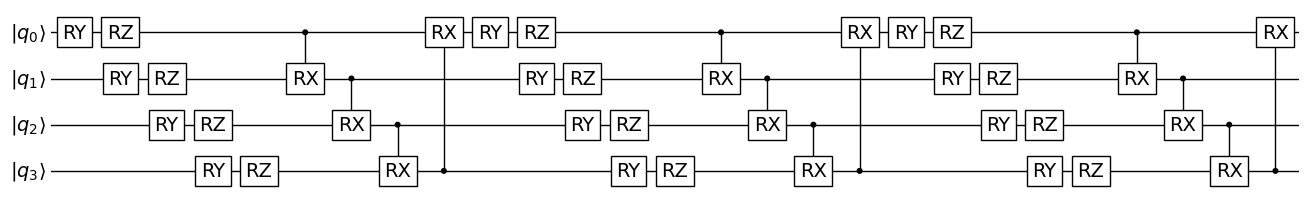

In [7]:
model = QuantumModel(
    circuit_structure=build_vqe_circuit(nqubits=nqubits, nlayers=nlayers),
    decoding=decoding,
)

_ = model.draw()

### Let's train!

In [8]:
print("Exact ground state: ", min(hamiltonian.eigenvalues()))

Exact ground state:  tensor(-6.7446, dtype=torch.float64)


In [9]:
optimizer = optim.Adam(model.parameters(), lr=0.05)

for iteration in range(300):
    optimizer.zero_grad()  
    cost = model()  
    cost.backward()  
    optimizer.step()  

    if iteration % 20 == 0:
        print(f"Iteration {iteration}: Cost = {cost.item():.6f}")

Iteration 0: Cost = -0.471007
Iteration 20: Cost = -5.387961
Iteration 40: Cost = -5.990623
Iteration 60: Cost = -6.153267
Iteration 80: Cost = -6.369555
Iteration 100: Cost = -6.604546
Iteration 120: Cost = -6.710510
Iteration 140: Cost = -6.738690
Iteration 160: Cost = -6.743156
Iteration 180: Cost = -6.743962
Iteration 200: Cost = -6.744113
Iteration 220: Cost = -6.744190
Iteration 240: Cost = -6.744234
Iteration 260: Cost = -6.744262
Iteration 280: Cost = -6.744281


We got it 🥳 !